### Churn model of public transports

---



---



Nowadays public transport is becoming more and more important in our lives. In the big cities, because of the volume of people who lives there and in the cities around. In the remote places, in order to maintain and reinforce the connections with other communities.

So, this repository is oriented to population movility. Especially in 
analysing public transports services, in order to improve them.

We have two databases, the first one, contains the bus users average by region, sex and age. It separate the information in two periods:

 - Reference population: Sep-19 to Feb-20.
 - Validation population: Sep-20 to Jan-21

The second one, is indexed by bus connection and it explains which is the preferred destination for every county of origin. This information is located in Portugal and it shows portuguese behaviours.

All this information will be used to analyse: 
 - If the usage of the bus has changed between the two periods.
 - Which are the main center of transportation and its roadmaps.   
 - To design a classification model which allow us classify the counties by their behaviour.

First of all, we import the python libraries and data bases.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from sklearn.cluster import AgglomerativeClustering, KMeans

In [ ]:
url = 'https://wdl-data.fra1.digitaloceanspaces.com/pse/Churn_UsersProfile.txt'
UserProfile = pd.read_csv(url, sep = '|', encoding="cp1252")
UserProfile = UserProfile.sort_values(['Region_of_Origin','District_of_Origin','County_of_Origin'])
#UserProfile

url = 'https://wdl-data.fra1.digitaloceanspaces.com/pse/Churn_OD.txt'
OD = pd.read_csv(url, sep = '|', encoding="cp1252")

In [ ]:
# both period and region are equally distributed by its values
period = UserProfile.groupby('Period')['Average_BusUsers_per_Day'].count()
region = UserProfile.groupby('Region_of_Origin')['Average_BusUsers_per_Day'].count()
print(period)
print("-----------------")
print(region)

Period
Sep-19 to Feb-20    255
Sep-20 to Jan-21    289
Name: Average_BusUsers_per_Day, dtype: int64
-----------------
Region_of_Origin
R1 - AM Lisboa    339
R2 - AM Porto     205
Name: Average_BusUsers_per_Day, dtype: int64


> #### Analysis by sex & age

---



---



In the next step, we agreggate the bus users by age and sex, then we calculate their distributions. The goal is to analyse if the number of bus users has changed in the two periods and to compare the bus users  distributions with the portuguese population, to find the differences of both populations.

In [ ]:
# Bus users database separeted by period
UP_PT_19 = UserProfile[UserProfile.Period == 'Sep-19 to Feb-20']
UP_PT_20 = UserProfile[UserProfile.Period == 'Sep-20 to Jan-21']

# Bus users age distribution
# We take 'Sep-19 to Feb-20' as reference period
UP_PT_age = UP_PT_19.groupby("AgeClassDescription")["Average_BusUsers_per_Day"].sum().round(2).reset_index()
UP_PT_age["Age_%"] = (UP_PT_age["Average_BusUsers_per_Day"] / UP_PT_age["Average_BusUsers_per_Day"].sum() * 100).round(2)
UP_PT_age = UP_PT_age.set_index("AgeClassDescription")
#UP_PT_age

In [ ]:
# Bus users weights by age; difference between periods; by Female genre
UP_PT_fem_19 = UP_PT_19[UP_PT_19.GenderDescription == 'Female'].groupby("AgeClassDescription")["Average_BusUsers_per_Day"].sum().round(2).reset_index()
UP_PT_fem_19 = UP_PT_fem_19.rename(columns ={ "Average_BusUsers_per_Day":"BusUsers_19"})
UP_PT_fem_19["Sex_Age_%"] = ((UP_PT_fem_19["BusUsers_19"] / UP_PT_fem_19["BusUsers_19"].sum() * 100).round(2))
UP_PT_fem_19 = UP_PT_fem_19.set_index("AgeClassDescription")

UP_PT_fem_20 = UP_PT_20[UP_PT_20.GenderDescription == 'Female'].groupby("AgeClassDescription")["Average_BusUsers_per_Day"].sum().round(2).reset_index()
UP_PT_fem_20 = UP_PT_fem_20.rename(columns = {"Average_BusUsers_per_Day":"BusUsers_20"})
UP_PT_fem_20 = UP_PT_fem_20.set_index("AgeClassDescription")

UP_PT_fem = UP_PT_fem_19.merge(UP_PT_fem_20, left_index = True, right_index = True)
UP_PT_fem["Dif_2019_2020_%"] = (100 * UP_PT_fem['BusUsers_20'] / UP_PT_fem['BusUsers_19']).round(2) 
UP_PT_fem["GenderDescription"] = "Female"
UP_PT_fem

# Bus users weights by age; difference between periods; by Male genre
UP_PT_mal_19 = UP_PT_19[UP_PT_19.GenderDescription == 'Male'].groupby("AgeClassDescription")["Average_BusUsers_per_Day"].sum().round(2).reset_index()
UP_PT_mal_19 = UP_PT_mal_19.rename(columns ={ "Average_BusUsers_per_Day":"BusUsers_19"})
UP_PT_mal_19["Sex_Age_%"] = ((UP_PT_mal_19["BusUsers_19"] / UP_PT_mal_19["BusUsers_19"].sum() * 100).round(2))
UP_PT_mal_19 = UP_PT_mal_19.set_index("AgeClassDescription")

UP_PT_mal_20 = UP_PT_20[UP_PT_20.GenderDescription == 'Male'].groupby("AgeClassDescription")["Average_BusUsers_per_Day"].sum().round(2).reset_index()
UP_PT_mal_20 = UP_PT_mal_20.rename(columns = {"Average_BusUsers_per_Day":"BusUsers_20"})
UP_PT_mal_20 = UP_PT_mal_20.set_index("AgeClassDescription")
UP_PT_mal = UP_PT_mal_19.merge(UP_PT_mal_20, left_index = True, right_index = True)
UP_PT_mal["Dif_2019_2020_%"] = (100 * UP_PT_mal['BusUsers_20'] / UP_PT_mal['BusUsers_19']).round(2) 
UP_PT_mal["GenderDescription"] = "Male"
UP_PT_sex = pd.concat([UP_PT_fem,UP_PT_mal])
UP_PT_age_sex = UP_PT_age.merge(UP_PT_sex, left_index = True, right_index = True).reset_index().set_index(["AgeClassDescription","GenderDescription"])
#UP_PT_age_sex

In [ ]:
# Portuguese population distribution. Data source: portdata.pt
pt_pop_csv = "./sample_data/portuguese_population_distribution.csv"
pt_pop = pd.read_csv(pt_pop_csv, sep = ";").set_index(["AgeClassDescription","GenderDescription"])

# final data base by sex, age and PT distribution
UP_age_sex_pt = UP_PT_age_sex.merge(pt_pop["total_pt_%"], right_index = True, left_index = True)
UP_age_sex_pt = UP_age_sex_pt[["Age_%","Sex_Age_%","total_pt_%","Dif_2019_2020_%"]]
print( "*Table 1.")
UP_age_sex_pt

*Table 1.


Age_%  ...  Dif_2019_2020_%
AgeClassDescription GenderDescription         ...                 
15-24               Female              9.90  ...            59.33
                    Male                9.90  ...            73.70
25-34               Female              8.52  ...            51.99
                    Male                8.52  ...            60.96
35-44               Female              7.56  ...            61.68
                    Male                7.56  ...            74.81
45-54               Female             11.68  ...            54.79
                    Male               11.68  ...            69.13
55-64               Female             13.18  ...            58.12
                    Male               13.18  ...            72.94
65+                 Female             49.17  ...            68.89
                    Male               49.17  ...            48.11

[12 rows x 4 columns]

In the table above we represent the weights by age and sex, same as the total portuguese population distribution. The last columns shows the bus usage in 2020 face of 2019, in percentage. 

Notice that 49% of bus users are older than 65 years old, while portuguese population represents around 20%.
In the sex_age column it is remarkable that Male young people use more the bus than Female (7.79% Girls vs 12.18% Boys). For the older groups the situation is inverted (50.79% Women vs 47.49% Men).

Regarding the column "difference" we see that both Male and Female have decreased their usage in every age range, mostly because of Covid restrictions. The chart below allow us analyse from other point of view.


*Plot 1.


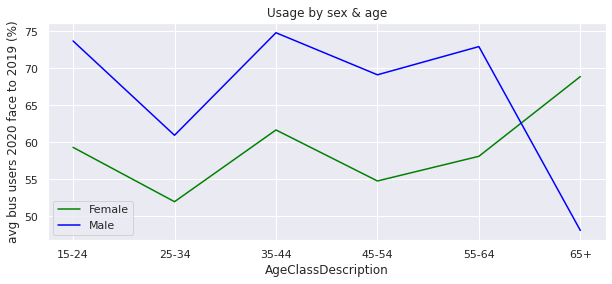

In [ ]:
# Chart showing the relative decrease by sex & age

UP_age_sex_pt = UP_age_sex_pt.reset_index().set_index("AgeClassDescription")
print( "*Plot 1.")
figure = plt.figure(figsize=(10, 4))
ax = figure.add_subplot(111)
UP_age_sex_pt[UP_age_sex_pt["GenderDescription"] == "Female"]["Dif_2019_2020_%"].plot(kind = 'line', color = 'green', ax=ax, label = 'Female')
UP_age_sex_pt[UP_age_sex_pt["GenderDescription"] == "Male"]["Dif_2019_2020_%"].plot(kind = 'line', color = 'blue', ax=ax, label  = 'Male')

plt.title('Usage by sex & age')
plt.ylabel("avg bus users 2020 face to 2019 (%)")
ax.legend(loc=3)
plt.show()

#UP_age_sex_pt

All the same, women usage have decreased, in average, more than 10 porcentual points than men. Except the segment 65+, which women relative usage face to 2019 is 70%, meanwhile same-age-men have moved in public transport 48% face to 2019.

From here we conclude:

 - Generalize decrease of bus usage.
 - Women usage drop is bigger than Men
 - Heaviest decrease: 25-34 Female and 65+ Male

So, in the next steps we will focus on these profiles to understand why do they have churned the bus services and we will propose how can we fight to encourage people get back to the public transport.


> #### Churn profiles by Top counties

---


Let's analyse by county. We search the most important by its usage. The goal here is to find the counties where "65+ Men" and "Women 25-34" have lost the most part of their users. We take again de reference population ('Sep-19 to Feb-20'). 



In [ ]:
# county top10 list from 2019 
# We obtain a list with the top10 counties of origin and we calculate their lost of passsengers.
UP_cnty_19 = UP_PT_19.groupby("County_of_Origin")["Average_BusUsers_per_Day"].sum().round(2).reset_index().set_index("County_of_Origin")
UP_cnty_19 = UP_cnty_19.rename(columns = {"Average_BusUsers_per_Day":"BusUsers_19"})
UP_cnty_20 = UP_PT_20.groupby("County_of_Origin")["Average_BusUsers_per_Day"].sum().round(2).reset_index().set_index("County_of_Origin")
UP_cnty_20 = UP_cnty_20.rename(columns = {"Average_BusUsers_per_Day":"BusUsers_20"})

UP_cnty = UP_cnty_19.merge(UP_cnty_20, left_index = True, right_index = True)
UP_cnty

UP_cnty["Dif_2019_2020_%"] = (UP_cnty["BusUsers_20"] / (UP_cnty["BusUsers_19"] ) * 100).round(2)
UP_cnty
top10_users_19 = UP_cnty.sort_values("BusUsers_19", ascending = False).round(2).head(10)
top10_users_list = top10_users_19.index.tolist()
print(top10_users_list)
#top10_users_19

['Gondomar', 'Maia', 'Porto', 'Lisboa', 'Oeiras', 'Vila Nova de Gaia', 'Odivelas', 'Matosinhos', 'Cascais', 'Vila Franca de Xira']


The list above represents the main Counties of origin. So, if there exists real difference between Men and Women by county it is more efficient to analyse starting for these cities.

In [ ]:
# Database creation by county, including relative difference for every sex & age combination. 
# Then we will filter it by the top10 counties user list of 2019.

# Pivot table by county (Average_BusUsers_per_Day) from 2019 
UP_top_churn_19 = UserProfile[(UserProfile["Period"] == "Sep-19 to Feb-20")]

UP_top_19_tot = UP_top_churn_19.pivot_table(values = "Average_BusUsers_per_Day", index = ["County_of_Origin"]
                                            , aggfunc = [np.sum]).rename(columns={"Average_BusUsers_per_Day":"Total_users"}).round(2)
UP_top_19_sex = UP_top_churn_19.pivot_table(values = "Average_BusUsers_per_Day", index = ["County_of_Origin"], 
                                            columns = ["GenderDescription"], aggfunc = [np.sum]).round(2)
UP_top_19_sex_age = UP_top_churn_19.pivot_table(values = "Average_BusUsers_per_Day", index = ["County_of_Origin"], 
                                            columns = ["GenderDescription","AgeClassDescription"]
                                            , aggfunc = [np.sum]).round(2)

UP_top_19_sex_age.columns = UP_top_19_sex_age.columns.droplevel(0)
UP_top_19 = UP_top_19_tot.merge(UP_top_19_sex,left_index=True, right_index=True)
UP_top_19 = UP_top_19.merge(UP_top_19_sex_age,left_index=True, right_index=True).fillna(0).sort_values(('sum', 'Total_users'), ascending = False)


################################## same table of 2020 ############

UP_top_churn_20 = UserProfile[(UserProfile["Period"] == "Sep-20 to Jan-21")]

UP_top_20_tot = UP_top_churn_20.pivot_table(values = "Average_BusUsers_per_Day", index = ["County_of_Origin"]
                                            , aggfunc = [np.sum]).rename(columns={"Average_BusUsers_per_Day":"Total_users"}).round(2)
UP_top_20_sex = UP_top_churn_20.pivot_table(values = "Average_BusUsers_per_Day", index = ["County_of_Origin"], 
                                            columns = ["GenderDescription"], aggfunc = [np.sum]).round(2)
UP_top_20_sex_age = UP_top_churn_20.pivot_table(values = "Average_BusUsers_per_Day", index = ["County_of_Origin"], 
                                            columns = ["GenderDescription","AgeClassDescription"]
                                            , aggfunc = [np.sum]).round(2)

UP_top_20_sex_age.columns = UP_top_20_sex_age.columns.droplevel(0)
UP_top_20 = UP_top_20_tot.merge(UP_top_20_sex,left_index=True, right_index=True)
UP_top_20 = UP_top_20.merge(UP_top_20_sex_age,left_index=True, right_index=True).fillna(0).sort_values(('sum', 'Total_users'), ascending = False)

# Data base joint
total_rutes = UP_top_19.merge(UP_top_20,left_index=True, right_index=True)

# Churn rate by county, sex and age
total_rutes_churn = total_rutes
total_rutes_churn["Total_churn"] = 100 * total_rutes[(   'sum_y', 'Total_users')] / total_rutes[(   'sum_x', 'Total_users')]
total_rutes_churn["Female_churn"] = 100 * total_rutes[(   'sum_y', 'Female_y')] / total_rutes[(   'sum_x', 'Female_x')]
total_rutes_churn["Male_churn"] = 100 * total_rutes[(   'sum_y', 'Male_y')] / total_rutes[(   'sum_x', 'Male_x')]
total_rutes_churn["Female_15_churn"] = 100 * total_rutes[('Female_y',       '15-24')] / total_rutes[('Female_x',       '15-24')]
total_rutes_churn["Female_25_churn"] = 100 * total_rutes[('Female_y',       '25-34')] / total_rutes[('Female_x',       '25-34')]
total_rutes_churn["Female_35_churn"] = 100 * total_rutes[('Female_y',       '35-44')] / total_rutes[('Female_x',       '35-44')]
total_rutes_churn["Female_45_churn"] = 100 * total_rutes[('Female_y',       '45-54')] / total_rutes[('Female_x',       '45-54')]
total_rutes_churn["Female_55_churn"] = 100 * total_rutes[('Female_y',       '55-64')] / total_rutes[('Female_x',       '55-64')]
total_rutes_churn["Female_65_churn"] = 100 * total_rutes[('Female_y',       '65+')] / total_rutes[('Female_x',       '65+')]
total_rutes_churn["Male_15_churn"] = 100 * total_rutes[('Male_y',       '15-24')] / total_rutes[('Male_x',       '15-24')]
total_rutes_churn["Male_25_churn"] = 100 * total_rutes[('Male_y',       '25-34')] / total_rutes[('Male_x',       '25-34')]
total_rutes_churn["Male_35_churn"] = 100 * total_rutes[('Male_y',       '35-44')] / total_rutes[('Male_x',       '35-44')]
total_rutes_churn["Male_45_churn"] = 100 * total_rutes[('Male_y',       '45-54')] / total_rutes[('Male_x',       '45-54')]
total_rutes_churn["Male_55_churn"] = 100 * total_rutes[('Male_y',       '55-64')] / total_rutes[('Male_x',       '55-64')]
total_rutes_churn["Male_65_churn"] = 100 * total_rutes[('Male_y',       '65+')] / total_rutes[('Male_x',       '65+')]

total_rutes_churn = total_rutes_churn.sort_values((   'sum_x', 'Total_users'), ascending = False)

# Keeping the churn variables
total_rutes_churn = total_rutes_churn[["Total_churn","Female_churn","Male_churn","Female_15_churn","Female_25_churn","Female_35_churn","Female_45_churn","Female_55_churn",
                                       "Female_65_churn","Male_15_churn","Male_25_churn","Male_35_churn","Male_45_churn","Male_55_churn","Male_65_churn"]].round(2)
total_rutes_churn.columns = total_rutes_churn.columns.droplevel(1)

# Filtering by the top10 counties user list of 2019
top_rutes_churn = total_rutes_churn[total_rutes_churn.index.isin(top10_users_list)]

# We keep the variables which represents our churn profiles
top_rutes_churn2 = top_rutes_churn[["Total_churn","Female_churn","Male_churn","Female_25_churn","Male_65_churn"]].round(2)


In the table below we have the relative difference between the two periods by sex and age, such as the total, for every top county of origin previously defined.

The biggest counties of origin are Gondomar, Maia and Porto (Three of them are in the metropolitan area of Porto). Furthermore, they have lost a half of their passengers between periods (Total churn).


*Plot 2.


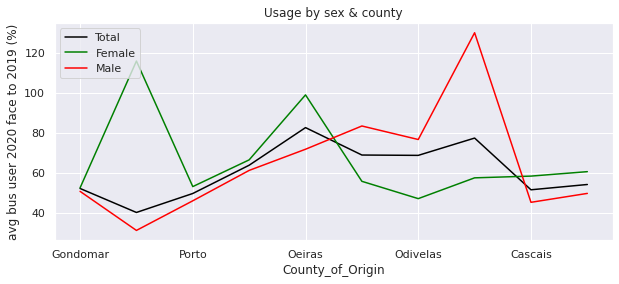

*Table 2.


,Total_churn,Female_churn,Male_churn,Female_25_churn,Male_65_churn
County_of_Origin,,,,,
Gondomar,52.05,52.35,50.61,64.12,44.10
Maia,40.04,115.84,31.05,30.14,22.19
Porto,49.54,52.99,45.88,42.02,51.37
Lisboa,63.69,66.37,61.09,48.89,77.50
Oeiras,82.52,98.90,71.69,2046.84,69.84
Vila Nova de Gaia,68.79,55.63,83.33,30.87,NaN
Odivelas,68.62,46.96,76.56,86.46,74.78
Matosinhos,77.28,57.37,130.01,20.65,inf
Cascais,51.39,58.24,45.12,54.00,inf


In [ ]:
# Plotting by County and Sex
print("*Plot 2.")
figure = plt.figure(figsize=(10, 4))
ax = figure.add_subplot(111)
top_rutes_churn["Total_churn"].plot(kind = 'line', color = 'black', ax=ax, label = 'Total')
top_rutes_churn["Female_churn"].plot(kind = 'line', color = 'green', ax=ax, label = 'Female')
top_rutes_churn["Male_churn"].plot(kind = 'line', color = 'red', ax=ax, label = 'Male')
plt.title('Usage by sex & county')
plt.ylabel("avg bus user 2020 face to 2019 (%)")

ax.legend(loc=2)
plt.show()
print("*Table 2.")
top_rutes_churn2

As wee see in the Table and Plot, Maia's Female churn shows 115% face to 2019, so usage has increased, in spite of "Maia Female 25-34" which have only a 30% of utilisation compared to 2019. So, the decrease of Women of these ages (51.99%, see Table 1) could be strongly caused by Maia's Female.

Regarding on 65+ Men, its churn is also especially dropped in Maia, face to general 65+ Male churn (48.11%).

Looking at the general lost of interest of portuguese population for the public transport, and especially in the case of these churn profiles, what we would like to propose is new roadmaps more fancy to the passengers in order to encourage them to go back to the public transport.

In our opinion, data can help so much, in this case, drawing up the currents bus roadmaps, then the goal is to compare them with the private vehicule roadmaps.

Other ways to increase the bus usage will be explained in the Future Work section.

> #### Concentration & Roadmaps

In the next step we search the main destination points, for that we need to import and work the second dataframe, OD Matrix and its more important variable, Demand weight.

The main task we develop here is to determine which are the principal roadmaps in the areas of Lisbon and Porto. With that intention, we take the biggest counties of origin of each Region and we cross them with the highest demand weight by Parish code. 


In [ ]:
# We translate the Parish code to Fregeusia
# https://dados.gov.pt/en/datasets/freguesias-de-portugal/#_
freg_csv = "./sample_data/freguesias-metadata.csv"
freg_df = pd.read_csv(freg_csv, sep = ";", encoding="cp1252")

freg_df = freg_df[["distrito","concelho","freguesia","dicofre"]]
#freg_df

In [ ]:
# Adding the Freguesia name
OD["Dicofre_ParishCode_of_Public_Transportation"] = OD["Dicofre_ParishCode_of_Public_Transportation"].astype(str)
OD_2 = OD.merge(freg_df, left_on = "Dicofre_ParishCode_of_Public_Transportation", right_on = "dicofre", how = 'inner')
#OD_2

In [ ]:
# Filtering by the most important counties of origin, then we obtain the Top Freguesia by Demand Weight
toprutes = OD_2[OD_2["County_of_Origin"].isin(top10_users_list)].sort_values("Demand_weight", ascending = False)

Top_freg = toprutes.groupby(['concelho','freguesia','dicofre'])['Demand_weight'].agg(['sum','count'])

Top_freg = Top_freg.sort_values("sum", ascending = False).head(15).reset_index()[["dicofre","freguesia","concelho","sum"]]
Top_freg = Top_freg.rename(columns = {"sum":"sum_DW"})
print("Table 3.")
Top_freg

Table 3.


,dicofre,freguesia,concelho,sum_DW
0,131217,"U.F. de Cedofeita, Santo Ildefonso, Sé, Mirag...",Porto,1.290334
1,131210,Paranhos,Porto,0.616139
2,110654,Alvalade,Lisboa,0.594779
3,130811,"U.F. de Custóias, Leça do Balio e Guifões",Matosinhos,0.574712
4,110658,Belém,Lisboa,0.505715
5,130814,U.F. de São Mamede de Infesta e Senhora da Hora,Matosinhos,0.397686
6,131730,U.F. de Santa Marinha e São Pedro da Afurada,Vila Nova de Gaia,0.373674
7,110633,Olivais,Lisboa,0.341078
8,110639,São Domingos de Benfica,Lisboa,0.330370
9,131203,Campanhã,Porto,0.322730


In the Table 3, we find the most concentrated areas of passengers reception. They will be commented next.

In [ ]:
# Then we cross top freguesias with top counties of origin. It returns the most influx roadmaps
roadmap = toprutes.merge(Top_freg, on = "dicofre", how = "inner").sort_values(["sum_DW","Demand_weight"], ascending = False)
top_roadmap = roadmap[roadmap["Demand_weight"] >=0.01][["County_of_Origin","Demand_weight","distrito","dicofre","freguesia_y","sum_DW"]].head(20)
print("Table 4.")
top_roadmap

Table 4.


,County_of_Origin,Demand_weight,distrito,dicofre,freguesia_y,sum_DW
10,Maia,0.380782,Porto,131217,"U.F. de Cedofeita, Santo Ildefonso, Sé, Mirag...",1.290334
11,Porto,0.365206,Porto,131217,"U.F. de Cedofeita, Santo Ildefonso, Sé, Mirag...",1.290334
12,Vila Nova de Gaia,0.243077,Porto,131217,"U.F. de Cedofeita, Santo Ildefonso, Sé, Mirag...",1.290334
13,Gondomar,0.172608,Porto,131217,"U.F. de Cedofeita, Santo Ildefonso, Sé, Mirag...",1.290334
14,Matosinhos,0.126859,Porto,131217,"U.F. de Cedofeita, Santo Ildefonso, Sé, Mirag...",1.290334
39,Porto,0.282090,Porto,131210,Paranhos,0.616139
40,Maia,0.159660,Porto,131210,Paranhos,0.616139
41,Matosinhos,0.074509,Porto,131210,Paranhos,0.616139
42,Gondomar,0.073846,Porto,131210,Paranhos,0.616139
43,Vila Nova de Gaia,0.024565,Porto,131210,Paranhos,0.616139


So, here we have the most important roadmaps by their influx. The main users reception point is "U.F.  de Cedofeita, Santo Ildefonso, Sé, Miragaia, São Nicolau e Vitória", in the center of Porto. All these users come from Maia, Vila Nova da Gaia, Gondomar, Matosinhos and also from Porto.

In Lisbon the main roadmaps arrive to Alvalade, from Vila Franca de Xira, Odivelas, Cascais, Oeiras and other Lisbon city points.

This information would be used in order to compare it with similar roadmaps drawn up by private vehicules connections.

> #### Conclusions




In short, there are big differences between periods, also analysing by sex, age and county. We have found several profiles which have decreased especially their bus usage. Also we can conclude that bus users distribution is quite different than portuguese population distribution. 

Young people does not like public transport, this is a very important point for two reasons: 

 - Because their activity and movility is so high, so it is crucial to encourage them to use public transport, because a little increase of this population segment provokes big private vehicule utilisation reductions.

 - Because they are the future, and they are the most interested people in having a  well distributed city and the greenest as posible, they have to understand how important is public transport for their future.

So, in order to encourage portuguese population, "BelManuel Soto" Team have thought in different solutions and iniciatives to improve the public transport network, because people will not change the transport for free, they will take the most efficient in terms of destination time, comfort and price, so, our job as analyst is to propose ideas and support projects which improve public transport services.

> #### Future Work

Finally, we want to achieve the last requirement, if we could have acces of every data in the world, what would we do with them? We would get two informations: geolocalisation and the area of influence of every public being, such as hospitals, schools or libraries, because these centers are installed in function of population density and necessesities.

On one hand, with the geolocalisation, we will compare the private vehicle roadmap with the existing public transport roadmaps. Then we could create new ones and optimize the currents. 

On the other hand, with the area of influence of the public beings, we could analyse if every neighbourhood inside this area is correctly communicated with the public beings or, if there is any quarter in which the citizens have to connect with different transports to arrive at their destinations.

Last, it would be very interesting to understand why some counties with the same characteristics, as peripheric areas of Lisbon and Porto, have different behaviours, why Oeiras have decreased its bus usage and Amadora doesn't?

To answer that question the first step is to classify the counties by its bus usage and quality of bus network. We define the quality of network in function of: public and private transport roadmaps comparison and connection with the public beings, the two subjects proposed above. 

Then we could compare similarities and differencies between the counties. Also, it would be very interesting to analyse other socio-demographic variables as type of job and number of vehicules per capita.  The model we propose is a cluster analysis because of its symplicity and its power of aggregation.

This model could be usefull for every public transport, not only for bus. In fact, the renovation of the public transport should include train, railway, taxi, car sharing... analysed every one separatedly, because passengers characteristics and necessities are different.